In [ ]:
# dataframe and series 
import pandas as pd
import numpy as np
from scipy import stats

# sklearn imports for modeling part
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import confusion_matrix

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE


In [ ]:

pd.options.display.max_columns=100 # To see the hidden columns in dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
data_url = "/content/sample30.csv"

data = pd.read_csv(data_url, parse_dates=True)
data.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    9957 non-null   object
 1   brand                 9957 non-null   object
 2   categories            9957 non-null   object
 3   manufacturer          9957 non-null   object
 4   name                  9957 non-null   object
 5   reviews_date          9943 non-null   object
 6   reviews_didPurchase   3659 non-null   object
 7   reviews_doRecommend   9408 non-null   object
 8   reviews_rating        9957 non-null   int64 
 9   reviews_text          9957 non-null   object
 10  reviews_title         9900 non-null   object
 11  reviews_userCity      1254 non-null   object
 12  reviews_userProvince  35 non-null     object
 13  reviews_username      9914 non-null   object
 14  user_sentiment        9956 non-null   object
dtypes: int64(1), object(14)
memory usage: 

In [ ]:
# converting reviews to str dtype 
data.reviews_username = data.reviews_username.astype(str)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
reviews_rating,9957.0,4.487496,0.847425,1.0,4.0,5.0,5.0,5.0


#DATA CLEANING

In [ ]:
# Missing % of each column

missing_df = round(100*data.isnull().sum()/len(data),2)
missing_df


id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.00
name                     0.00
reviews_date             0.14
reviews_didPurchase     63.25
reviews_doRecommend      5.51
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.57
reviews_userCity        87.41
reviews_userProvince    99.65
reviews_username         0.00
user_sentiment           0.01
dtype: float64

In [ ]:
# Dropping columns with missing values more than 25 %

data.drop(missing_df[missing_df > 25].index.tolist(), axis = 1, inplace = True)

In [ ]:
round(100*data.isnull().sum()/len(data),4)

id                     0.0000
brand                  0.0000
categories             0.0000
manufacturer           0.0000
name                   0.0000
reviews_date           0.1406
reviews_doRecommend    5.5137
reviews_rating         0.0000
reviews_text           0.0000
reviews_title          0.5725
reviews_username       0.0000
user_sentiment         0.0100
dtype: float64

In [ ]:
data.isnull().sum()

id                       0
brand                    0
categories               0
manufacturer             0
name                     0
reviews_date            14
reviews_doRecommend    549
reviews_rating           0
reviews_text             0
reviews_title           57
reviews_username         0
user_sentiment           1
dtype: int64

In [ ]:
#Dropping Null value rows from user_sentiment

data = data[data['user_sentiment'].notna()]

In [ ]:
#Choosing columns which are Relevant for the Analysis

df= data[['brand', 'categories', 'manufacturer', 'name',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_title', 'reviews_username', 'user_sentiment']]

In [ ]:
# Mapping categorical to 1/0

df['reviews_doRecommend'] = df['reviews_doRecommend'].map(dict([(False,0),(True,1)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['user_sentiment'] = df['user_sentiment'].map(dict([('Negative',0),('Positive',1)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9956 entries, 0 to 9955
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                9956 non-null   object 
 1   categories           9956 non-null   object 
 2   manufacturer         9956 non-null   object 
 3   name                 9956 non-null   object 
 4   reviews_doRecommend  9407 non-null   float64
 5   reviews_rating       9956 non-null   int64  
 6   reviews_text         9956 non-null   object 
 7   reviews_title        9900 non-null   object 
 8   reviews_username     9956 non-null   object 
 9   user_sentiment       9956 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 855.6+ KB


EDA

In [ ]:
# Distribution of the rating

df['reviews_rating'].value_counts() 

5    6312
4    2813
3     447
1     244
2     140
Name: reviews_rating, dtype: int64

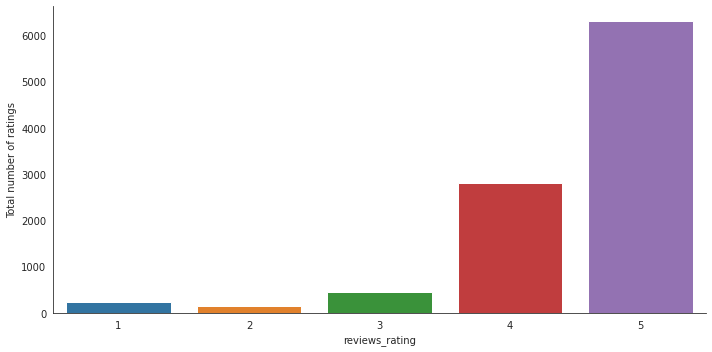

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot( x='reviews_rating', data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
# Unique Users and products

print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.reviews_username)))
print("Total No of products  :", len(np.unique(df.name)))

Total data 
--------------------------------------------------

Total no of ratings : 9956
Total No of Users   : 9177
Total No of products  : 91


In [ ]:
# Analyzing the rating

no_of_rated_products_per_user = df.groupby(by='reviews_username')['reviews_rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviews_username
nan      42
chris    15
mike     10
cindy     7
john      7
Name: reviews_rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()

count    9177.000000
mean        1.084886
std         0.584871
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        42.000000
Name: reviews_rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

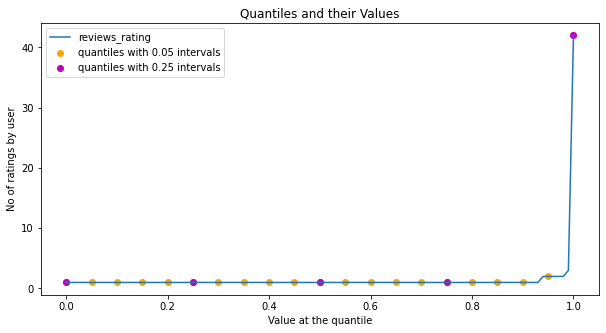

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 15 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 15)) )


 No of rated product more than 15 per user : 2



DATA PROCESSING

In [ ]:
# Converting to lower case

df['reviews_text']=df['reviews_text'].str.lower() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Preprocessing the Reviews_text - Removing the punctuation

import string
string.punctuation # to see punctuation library of string function

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punctuation(text):
   
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc

In [ ]:
#removing punctuation & adding review header & review text after cleaning to a new column

df['reviews_text_clean'] = df['reviews_title'].apply(lambda x: remove_punctuation(str(x))) + ' ' + df['reviews_text'].apply(lambda x: remove_punctuation(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['reviews_text_clean']

0       Just Awesome i love this album its very good m...
1       Good good flavor this review was collected as ...
2                                        Good good flavor
3       Disappointed i read through the reviews on her...
4       Irritation my husband bought this gel for us t...
                              ...                        
9951    A must i have always used clorox wipes in the ...
9952    Love Em i love clorox wipes i feel confident t...
9953    Convenient and easy to use the clorox wipes is...
9954    I love clorox clorox is awesome to clean my ho...
9955    Loving me some clorox i absolutely love everyt...
Name: reviews_text_clean, Length: 9956, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9956 entries, 0 to 9955
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                9956 non-null   object 
 1   categories           9956 non-null   object 
 2   manufacturer         9956 non-null   object 
 3   name                 9956 non-null   object 
 4   reviews_doRecommend  9407 non-null   float64
 5   reviews_rating       9956 non-null   int64  
 6   reviews_text         9956 non-null   object 
 7   reviews_title        9900 non-null   object 
 8   reviews_username     9956 non-null   object 
 9   user_sentiment       9956 non-null   int64  
 10  reviews_text_clean   9956 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.2+ MB


In [ ]:
# Creating Positive sentiment Wordcloud
# setting stop words

stop_words = set(STOPWORDS) 

In [ ]:
# positive reviews dataframe

df_pos = df.loc[df['user_sentiment']==1] 

In [ ]:
# assigning word cloud 

wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 500,
                    max_font_size = 100, random_state = 42, width=600, height=300)

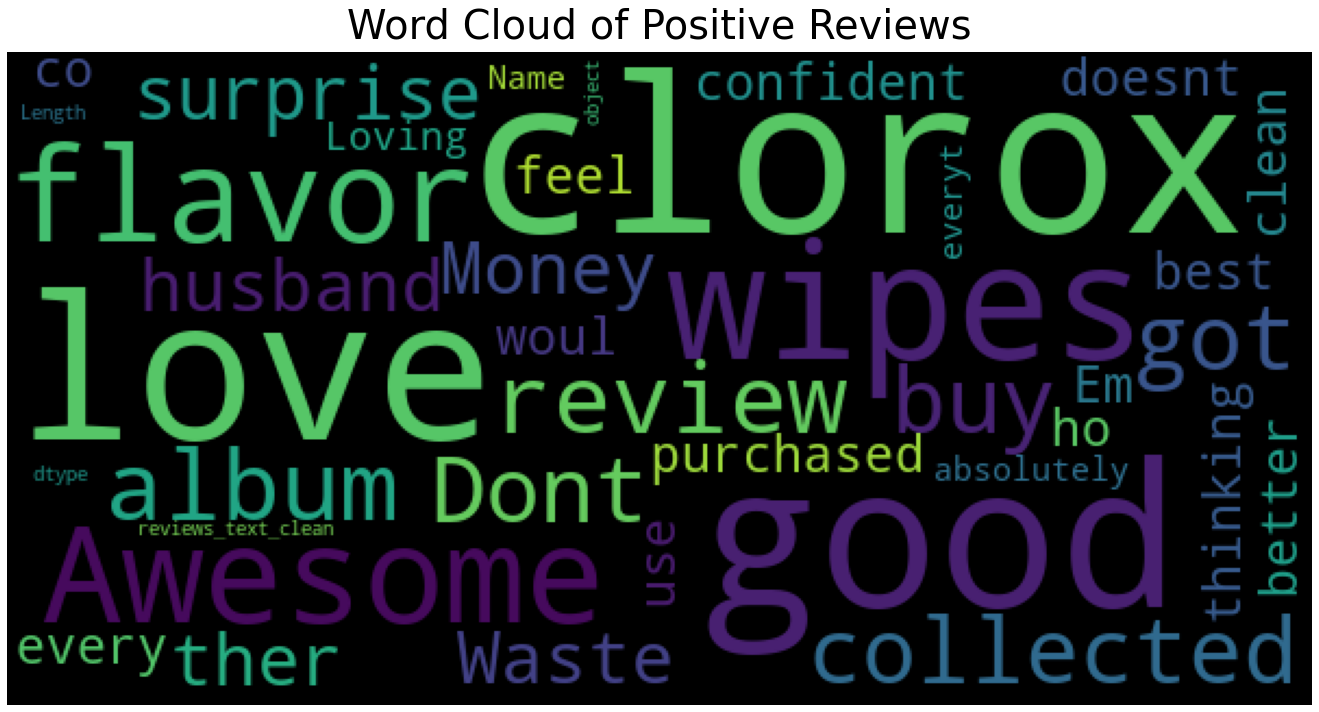

In [ ]:
# to see the positive reviews wordcloud

wordcloud.generate(str(df_pos['reviews_text_clean']))
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Positive Reviews", fontdict={'size': 40, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout() 

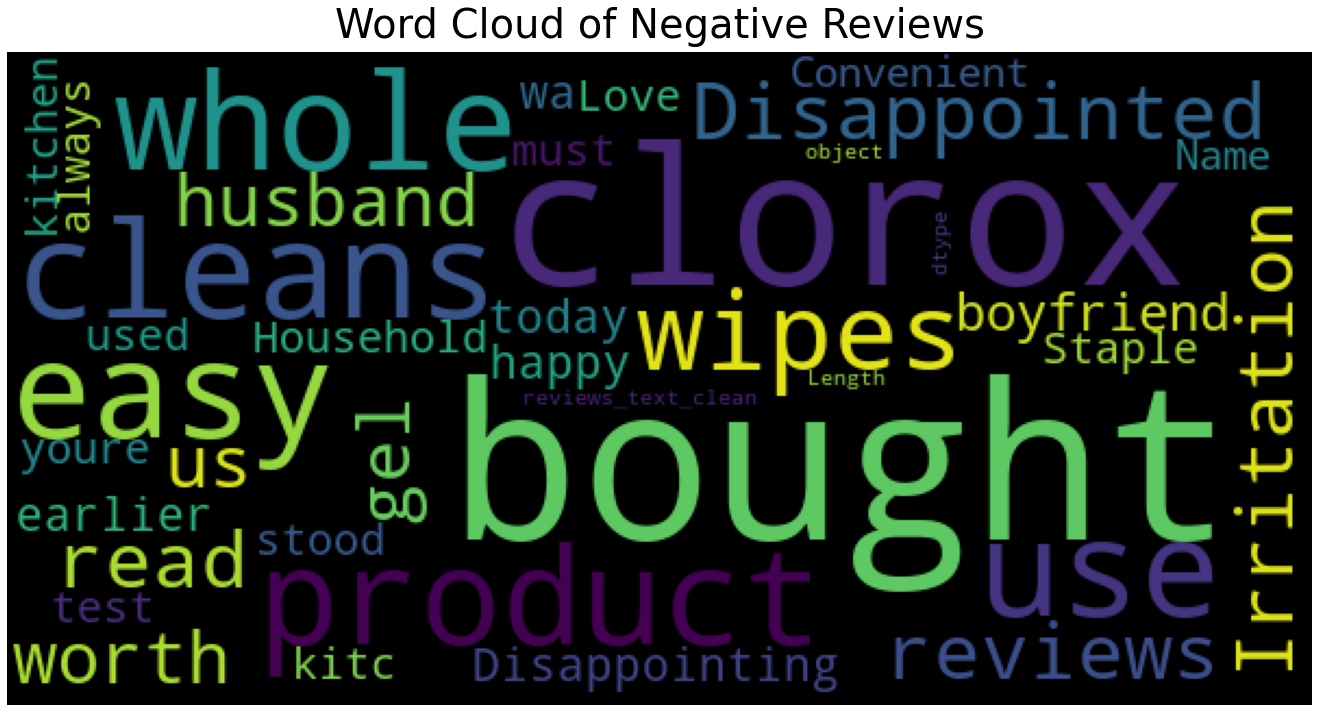

In [ ]:
# Creating Negative sentiment Wordcloud

df_neg = df.loc[df['user_sentiment']==0] # Negative reviews dataframe

# to see the Negative reviews wordcloud
wordcloud.generate(str(df_neg['reviews_text_clean']))
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Negative Reviews", fontdict={'size': 40, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout() 

In [ ]:

# Custom functions to Look Most Common Positive and Negative Words

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def word_count(reviews):
    
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num

In [ ]:
# Top 25 Common Words List in Positive Reviews

word_frequency=word_count(df_pos['reviews_text_clean']) 

In [ ]:
# to create dataframe from most common words dictionary

df_pos_count = pd.DataFrame(columns=['word', 'count'])
df_pos_count['word'] = word_frequency.keys()
df_pos_count['count'] = list(word_frequency.values())
df_pos_count=df_pos_count.sort_values(by=['count'], ascending=False)
df_pos_count=df_pos_count.reset_index(drop=True)

In [ ]:
stop = set(stopwords.words("english")) #setting stopwords

In [ ]:
# taking only words which are not stopwords
df_pos_count['word_without_stop'] = df_pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df_pos_without_stop = df_pos_count.dropna(subset=['word_without_stop'])

In [ ]:
df_top_25_pos = df_pos_count.loc[df_pos_count['word_without_stop']!=''].head(25)

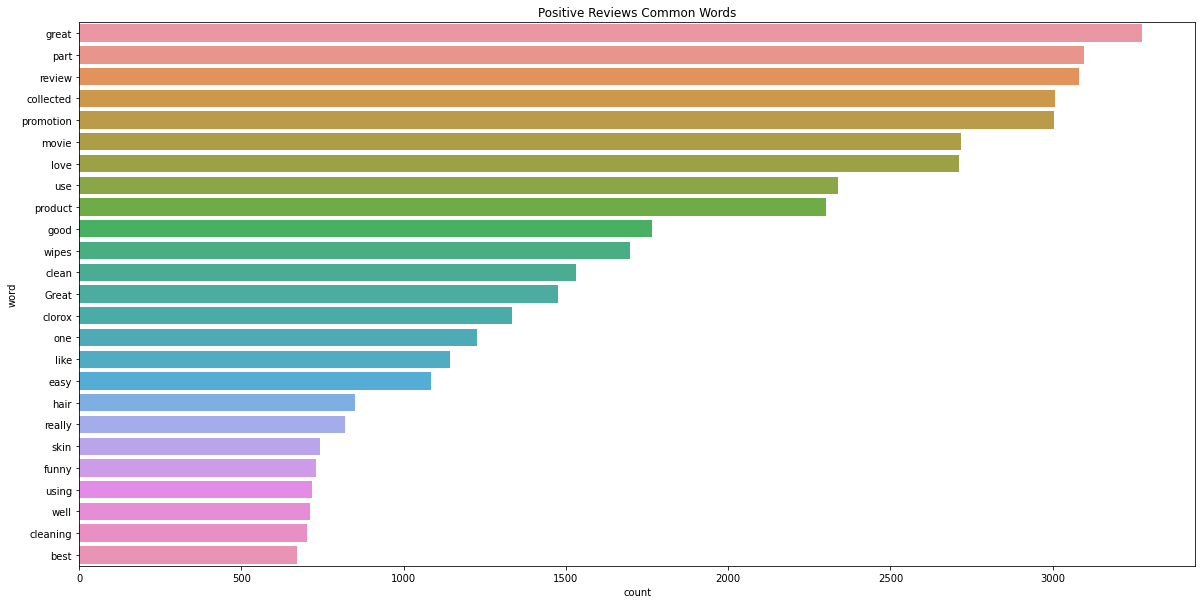

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Positive Reviews Common Words')
sns.barplot(y="word",x="count", data=df_top_25_pos)

In [ ]:
# Top 25 Common Words List in Negative Reviews

word_frequency_neg=word_count(df_neg['reviews_text_clean'])
word_frequency_neg

{'Disappointed': 2,
 'i': 1183,
 'read': 5,
 'through': 15,
 'the': 1306,
 'reviews': 11,
 'on': 256,
 'here': 11,
 'before': 23,
 'looking': 19,
 'in': 379,
 'to': 714,
 'buying': 11,
 'one': 145,
 'of': 751,
 'couples': 1,
 'lubricants': 1,
 'and': 857,
 'was': 571,
 'ultimately': 1,
 'disappointed': 41,
 'that': 239,
 'it': 718,
 'didnt': 26,
 'even': 42,
 'live': 9,
 'up': 93,
 'had': 108,
 'for': 464,
 'starters': 1,
 'neither': 1,
 'my': 500,
 'boyfriend': 2,
 'nor': 5,
 'could': 35,
 'notice': 4,
 'any': 48,
 'sort': 5,
 'enhanced': 2,
 'or': 69,
 'captivating': 2,
 'sensation': 2,
 'what': 74,
 'we': 102,
 'did': 52,
 'however': 9,
 'messy': 10,
 'consistency': 2,
 'reminiscent': 1,
 'a': 1019,
 'more': 21,
 'liquidy': 1,
 'vaseline': 1,
 'difficult': 6,
 'clean': 38,
 'not': 266,
 'pleasant': 1,
 'especially': 18,
 'since': 33,
 'lacked': 1,
 'both': 16,
 'been': 69,
 'expecting': 6,
 'im': 45,
 'paid': 4,
 'as': 447,
 'much': 28,
 'lube': 1,
 'wont': 13,
 'use': 291,
 'again'

In [ ]:
df_neg_count = pd.DataFrame(columns=['word', 'count'])
df_neg_count['word'] = word_frequency_neg.keys()
df_neg_count['count'] = list(word_frequency_neg.values())
df_neg_count=df_neg_count.sort_values(by=['count'], ascending=False)
df_neg_count=df_neg_count.reset_index(drop=True)

In [ ]:
df_neg_count['word_without_stop'] = df_neg_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df_neg_without_stop = df_neg_count.dropna(subset=['word_without_stop'])
df_top_25_neg = df_neg_count.loc[df_neg_count['word_without_stop']!=''].head(25)

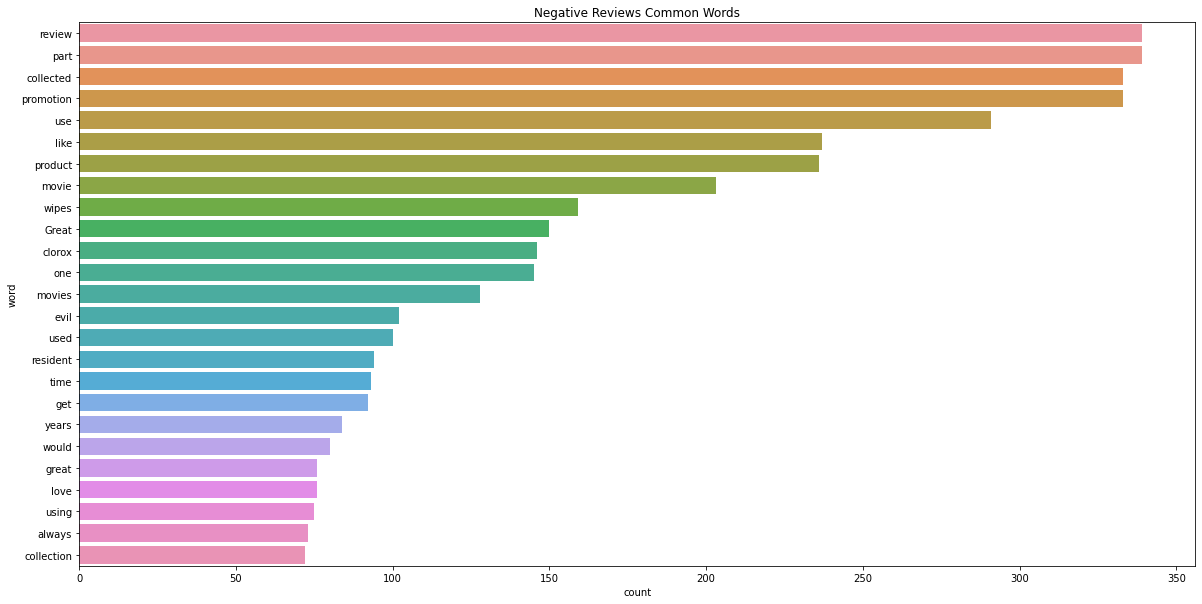

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Negative Reviews Common Words')
sns.barplot(y= "word",x="count", data=df_top_25_neg)

SENTIMENT MODELLING

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

LOGISTIC REGRESSION MODELLING

In [ ]:
def logreg_model(df) :
      
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = LogisticRegression(class_weight = "balanced") #, C=0.5, solver='sag')

    # Hyperparameter Tuning
    C = [(x) for x in np.logspace(start = 0 , stop = 4, num = 11)] # returns 11 numbers 
    penalty = ["l1","l2"]
    solver = ["liblinear", "saga"]
    r_grid = {'C': C, 'penalty': penalty, 'solver': solver}

    grid = {"C":np.logspace(-3,3,10), "penalty":["l1","l2"]}# l1 lasso l2 ridge
    logreg_cv = RandomizedSearchCV(estimator=classifier, param_distributions= r_grid, cv=3, n_iter = 20, scoring='f1', verbose=2, random_state=31, n_jobs=-1, return_train_score=True)
    logreg_cv.fit(train_word_features,y_train.values.ravel())

    print_results(logreg_cv)
    # calculating results 
    
    best_lr = LogisticRegression(class_weight = "balanced", **logreg_cv.best_params_)
    best_lr.fit(train_word_features,y_train)

    y_pred_train = best_lr.predict(train_word_features)
    y_pred = best_lr.predict(test_word_features)
    
    print(best_lr.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(7964,)
(1992,)
(14030, 10000)
(14030,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


BEST PARAMS: {'solver': 'saga', 'penalty': 'l2', 'C': 1584.893192461114}

0.928 (+/-0.016) for {'solver': 'liblinear', 'penalty': 'l1', 'C': 1584.893192461114}
0.932 (+/-0.008) for {'solver': 'liblinear', 'penalty': 'l1', 'C': 251.18864315095823}
0.89 (+/-0.014) for {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
0.907 (+/-0.013) for {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}
0.923 (+/-0.012) for {'solver': 'saga', 'penalty': 'l1', 'C': 2.51188643150958}
0.942 (+/-0.009) for {'solver': 'saga', 'penalty': 'l2', 'C': 1584.893192461114}
0.942 (+/-0.005) for {'solver': 'saga', 'penalty': 'l2', 'C': 39.810717055349734}
0.933 (+/-0.004) for {'solver': 'liblinear', 'penalty': 'l2', 'C': 630.9573444801937}
0.936 (+/-0.009) for {'solver': 'saga', 'penalty': 'l1', 'C': 6.309573444801933}
0.942 (+/-0.01) for {'solver': 'saga', 'penalty': 'l1', 'C': 10000.0}
0.941 (+/-0.006) for {'solver': 'saga', 'penalty': 'l1', 'C': 15.848931924611142}
0.935 (+/-0.01) for {'solver': 'liblinear', 'pen

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


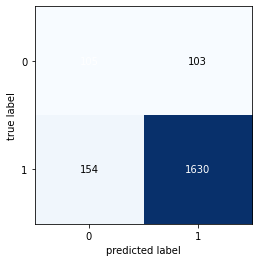

In [ ]:
logreg_model(df)

RANDOM FOREST MODEL

In [ ]:
def rf_model(df) :
        
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = RandomForestClassifier(class_weight = "balanced")

    # Hyperparameter Tuning
    n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 
    max_features = ['auto', 'log2']
    max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 
    max_depth.append(None)
    bootstrap = [True, False]
    r_grid = {'n_estimators': n_estimators,

               'max_features': max_features,

               'max_depth': max_depth,

               'bootstrap': bootstrap}

    cv= RandomizedSearchCV(estimator=classifier, param_distributions=r_grid, n_iter = 20, scoring='f1', 
                      cv = 3, verbose=2, random_state=31, n_jobs=-1, return_train_score=True)
    cv.fit(train_word_features,y_train.values.ravel())
    print_results(cv)
    
    # calculating results 
    y_pred_train = cv.predict(train_word_features)
    y_pred = cv.predict(test_word_features)

    best_random = RandomForestClassifier(class_weight = "balanced", **cv.best_params_)
    best_random.fit(train_word_features,y_train)

    print(best_random.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(7964,)
(1992,)
(14030, 10000)
(14030,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
BEST PARAMS: {'n_estimators': 15, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}

0.947 (+/-0.028) for {'n_estimators': 15, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
0.706 (+/-0.07) for {'n_estimators': 9, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': False}
0.666 (+/-0.022) for {'n_estimators': 8, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
0.908 (+/-0.002) for {'n_estimators': 6, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
0.375 (+/-0.398) for {'n_estimators': 6, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}
0.915 (+/-0.02) for {'n_estimators': 10, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
0.7 (+/-0.035) for {'n_estimators': 15, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}
0.941 (+/-0.031) for {'n_estimators': 9, 'max_features': 'auto', 'max_depth': None, 'boots

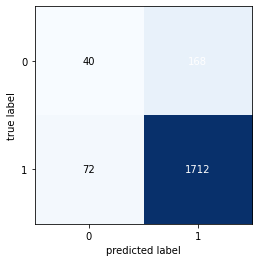

In [ ]:
rf_model(df)

XGBOOST MODEL

In [ ]:
def xg_model(df) :
        
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = xgb.XGBClassifier()

    # Hyperparameter Tuning
    param_dist = {
    'n_estimators':[100, 200,500,750,1000],
    'min_child_weight':[1,5,7,10], 
    'gamma':[i/10.0 for i in range(1,7)],  
    'subsample':[i/10.0 for i in range(3,9)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie', 'binary:logistic'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,9)],
}


    cv = RandomizedSearchCV(estimator = classifier, 
                            param_distributions = param_dist,
                            cv = 3,  
                            n_iter = 20, 
                            scoring = 'f1', 
                            error_score = 0, 
                            verbose = 3, 
                            n_jobs = -1, random_state=31, return_train_score=True)

    cv.fit(train_word_features,y_train.values.ravel())
    print_results(cv)
    
    # calculating results 
    y_pred_train = cv.predict(train_word_features)
    y_pred = cv.predict(test_word_features)

    best_xgb = xgb.XGBClassifier(**cv.best_params_)
    best_xgb.fit(train_word_features,y_train)

    print(best_xgb.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(7964,)
(1992,)
(14030, 10000)
(14030,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
BEST PARAMS: {'subsample': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.2, 'eval_metric': 'rmse', 'eta': 0.6, 'colsample_bytree': 0.9, 'booster': 'gbtree'}

0.723 (+/-0.015) for {'subsample': 0.3, 'objective': 'reg:tweedie', 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 0.6, 'eval_metric': 'rmse', 'eta': 0.5, 'colsample_bytree': 0.7, 'booster': 'gblinear'}
0.845 (+/-0.056) for {'subsample': 0.3, 'objective': 'reg:tweedie', 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 7, 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.5, 'colsample_bytree': 1.0, 'booster': 'gbtree'}
0.913 (+/-0.075) for {'subsample': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 750, 'min_child_weight': 7, 'max_depth': 4, 'gamma': 0.4, 'eval_metric': 'rmse', 'eta': 0.4, 'colsample_bytree': 0.9, 'booster': 'gbtree'}
0

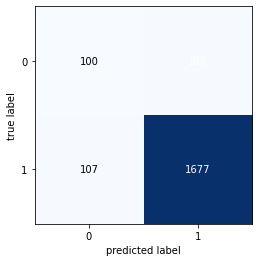

In [ ]:
xg_model(df)

NAIVE BAYES MODELLING

In [ ]:
def NaiveBayes_model(df) :
      
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)

    # choosing and fitting classifier
    classifier = GaussianNB()

    # Hyperparameter Tuning
    param_dist = {
    'var_smoothing': np.logspace(0,-5, num=100)
    }


    cv = RandomizedSearchCV(estimator = classifier, 
                            param_distributions = param_dist,
                            cv = 3,  
                            n_iter = 10, n_jobs = 1,
                            scoring = 'f1', error_score = 0,
                            verbose = 0, 
                            random_state=31, return_train_score=False)

    cv.fit(train_word_features.toarray(),y_train.values.ravel())
    print_results(cv)
    
    # calculating results 
    y_pred_train = cv.predict(train_word_features.toarray())
    y_pred = cv.predict(test_word_features.toarray())

    best_nb = GaussianNB(**cv.best_params_)
    best_nb.fit(train_word_features.toarray(),y_train.values.ravel())

    print(best_nb.score(test_word_features.toarray() , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

(7964,)
(1992,)
(14030, 10000)
(14030,)
BEST PARAMS: {'var_smoothing': 0.0009326033468832199}

0.191 (+/-0.093) for {'var_smoothing': 0.1384886371393873}
0.499 (+/-0.055) for {'var_smoothing': 0.021544346900318832}
0.695 (+/-0.011) for {'var_smoothing': 0.000145082877849594}
0.026 (+/-0.029) for {'var_smoothing': 0.7054802310718643}
0.702 (+/-0.012) for {'var_smoothing': 0.001484968262254465}
0.01 (+/-0.017) for {'var_smoothing': 1.0}
0.568 (+/-0.039) for {'var_smoothing': 0.013530477745798068}
0.07 (+/-0.054) for {'var_smoothing': 0.39442060594376555}
0.706 (+/-0.008) for {'var_smoothing': 0.0009326033468832199}
0.702 (+/-0.008) for {'var_smoothing': 0.00041320124001153384}
0.5481927710843374
Accuracy:
TRAIN: 0.826015680684248
TEST: 0.5481927710843374
F1-Score:
TRAIN: 0.789369229441712
TEST: 0.6890117484450587


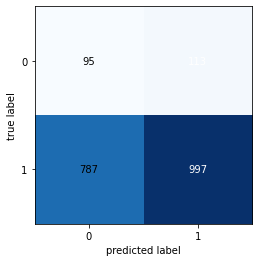

In [ ]:
NaiveBayes_model(df)

MODEL SELECTION

Considering F1-Score as the scoring measure as it will penalise model for both FP & FN, in above 3 models, performance of XGBoost is highest.

Accuracy:
TRAIN: 0.9814

TEST: 0.8948

F1-Score:
TRAIN: 0.9814

TEST: 0.9400

USER BASED RECOMMENDATION SYSTEM

In [ ]:
# Splitting data into Train & Test

train, test = train_test_split(df, test_size=0.2, random_state=31)
print(train.shape)
print(test.shape)

(7964, 11)
(1992, 11)


In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product_names and the rows are user_names.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

In [ ]:
# Creating dummy train & dummy test dataset

# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [ ]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Convert the dummy train dataset into matrix format.
dummy_train = pd.pivot_table( dummy_train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

USER SIMILARITY MATRIX

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        0.        ... 0.        0.        0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [ ]:
user_correlation.shape

(7422, 7422)

USING ADJUSTED COSINE

In [ ]:
# User - Product Matrix

#Here, we are not removing the NaN values and calculating the mean only for the products rated by the user
# Create a user-product matrix.
df_pivot = pd.pivot_table( train,
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

df_pivot.head(3)

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

Normalising the rating of the Product for each user around 0 mean

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head(3)

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

In [ ]:
# Finding cosine similarity

from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Prediction - User 

user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[6.68383639, 0.        , 1.60128154, ..., 0.        , 8.10308895,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
user_predicted_ratings.shape

(7422, 86)

In [ ]:
# Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head(3)

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

Evaluation - User

In [ ]:
# To evaluate, we will predict for the products already rated by the user insead of predicting it for the products not rated by the user.

# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(211, 11)

In [ ]:
common.head

<bound method NDFrame.head of                      brand                                         categories  \
1238                Finish  Household Essentials,Cleaning Supplies,Dish De...   
2128                   FOX  Movies & TV Shows,Movies,Romance,Romantic Come...   
387                   Olay  Personal Care,Skin Care,Anti-Aging,Beauty,Face...   
5514          Warner Bros.  Movies, Music & Books,Movies,New Movie Release...   
5743  Summit Entertainment  Movies & TV Shows,Instawatch Movies By VUDU,Sh...   
...                    ...                                                ...   
946                 Windex  Household Essentials,Cleaning Supplies,Glass C...   
5387        Super PoliGrip  Personal Care,Oral Care,Denture Care,Health & ...   
1886                   FOX  Movies & TV Shows,Movies,Romance,Romantic Come...   
1339           Banana Boat  Personal Care,Makeup,Bronzer,Beauty,Skin Care,...   
1179                Disney  Movies, Music & Books,Movies,Kids' & Family,Mo...  

In [ ]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [ ]:
df_subtracted.head(1)

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

In [ ]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,7372,7373,7374,7375,7376,7377,7378,7379,7380,7381,7382,7383,7384,7385,7386,7387,7388,7389,7390,7391,7392,7393,7394,7395,7396,7397,7398,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408,7409,7410,7411,7412,7413,7414,7415,7416,7417,7418,7419,7420,7421
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10ten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1143mom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

(190, 7422)

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
print(user_correlation_df_3.shape)
user_correlation_df_3.head()

(190, 190)


,85lisa,abcssds,adam,aj2012,ajface24,alex,allen,amishmom,amy1,andi,andy,angel,angie,ann222,annie,ashleylysette,babumsky,barbarajean,becky25,bigdaddy,bill,blessedmomma,bob,bobby,bobo,brandon,brooke,buckleyshoppiong,burntpopcorn,capnscrummy,carrot1991,castle,charles,chris,christine,chrystal1101,coach,cristalr,dale,danny,dawn,ddstump,debra,dee,diane,disappointedmom,draya77,drew,dukefan1979,e8181,...,petals66,photogeek200,pimc-utta,pooky,qegr,rblve57,rbs522,redhead,regal76,renuvatio,reset,rick,rocky,ronnie,rosie,sammy,sandi,scott,sharon530,shelly,shirl,shortride,smkaddy,solo,sparky,spunky,stacyconnell,steph,suewho,suri,sverm,synoptic 12,the dustbusters,thecleaninglady,thequeen,thirsty23,tina,toni,tony,tooney38,turi,tw350z,txmomof6,val,viking80,vivienne,warren,worm,xcoupon,zitro
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abcssds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aj2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ajface24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [ ]:
dummy_test.shape

(190, 36)

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),"Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Hawaiian Punch Berry Limeade Blast Juice,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","Johnson's Baby Bubble Bath and Wash, 15oz",Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz",Olay Regenerist Deep Hydration Regenerating Cream,Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Pink Friday: Roman Reloaded Re-Up (w/dvd),Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abcssds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculating the RMSE for only the products rated by user

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.1475058372414035


Item Based Recommendation System

In [ ]:
# Taking the transpose of the rating matrix to normalize the rating around the mean for different products.

df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head(3)

reviews_username,00sab00,08dallas,10ten,1143mom,1234,1234567,123cat123,123charlie,123soccermom,123too,127726,13thfaerie,1421nikki,143st,19granny,1awesome1,1chynna,1gamer,1gussy,1jodie,1kindword,1olaygal,1scooby1,1sonny,1stcavdivision,1stlady,1witch,2014bestbuys,2062351337,21honey,232323,2532674594,2827,2athome,2busy4u,2clean4me,2go4savings,2shoes,2w0cat5z,30103,3276teev,37f5p,38redsox,3dcav,3lilones,4 rooms 1 dog lotsa fur,4048197640,4112,4cloroxl,4djs,...,yopack,yorissa,yorkielvr,yorkster88,yosh,yoshi,yosuerte,younggrannie62,yourbugginme04,youthfulone,yttric,yummy,yunji,yyz2112123,z12345,z33pisces,zachsmom,zakkwylde29,zanarkandruinsx2,zanzan73,zapman,zarah,zaza,zebras,zee74,zeeleader,zegan,zenmon,zer0zer0agent,zeroonec,zibber23,zink,zitro,zmom,zodness,zoeellasca,zoey,zombiedad80,zombiekiller,zoney86,zooey_57,zotox,zozo0o,zpalma,zsarah,zulaa118,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ambi Complexion Cleansing Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Normalising the product rating for each product for using the Adujsted Cosine

mean = np.nanmean(df_pivot, axis=1)

In [ ]:
df_subtracted = (df_pivot.T-mean).T

In [ ]:
# Finding the cosine similarity using pairwise distances approach

item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')

In [ ]:
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.         -0.00513708
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.00513708  0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [ ]:
# Filtering the correlation only for which the value is greater than 0

item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# Prediction - Item

item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[5.10081173e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.69286740e-03, 1.24268243e-02],
       [5.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.92556809e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.50782070e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.44881123e-02, 2.07113738e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.30156414e-03]])

In [ ]:
item_predicted_ratings.shape
dummy_train.shape

(7422, 86)

In [ ]:
# Filtering the rating only for the movies not rated by the user for recommendation

item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,100:Complete First Season (blu-Ray),Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Calvin Klein Secret Obsession Eau De Parfum,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca,Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Herr's Baked Cheese Curls,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,King Ralph (dvd),La Tortilla Factory Hand Made Style Tortillas Flour,Lundberg Organic Cinnamon Toast Rice Cakes,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Organics Licorice Twist, Black 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,Pearhead Id Bracelet Frame,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Pinaud Clubman Styling Gel, Superhold",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Ceiling Fan - White,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Toy Story Kids' Woody Accessory Kit,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Windex Original Glass Cleaner Refill 

In [ ]:
# Evaluation

common =  test[test.name.isin(train.name)]
common.shape

(1987, 11)

In [ ]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
common_item_based_matrix.shape

(62, 1941)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005417,0.0,0.0,0.0,0.0,0.0,0.0,0.008479,0.020813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005249,0.0,0.0,0.0,0.0,0.002921,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005417,0.0,0.0,0.0,0.0,0.0,0.0,0.008479,0.020813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005249,0.0,0.0,0.0,0.0,0.002921,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ambi Complexion Cleansing Bar,0.0,0.0,1.0,0.0,0.0,0.292557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common.name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

In [ ]:
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

In [ ]:
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,100:Complete First Season (blu-Ray),Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bumble Bee Solid White Albacore In Water - 5 Oz,Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Chex Muddy Buddies Brownie Supreme Snack Mix,Clambake (dvd),Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Colorganics Lipstick, Cayenne","Creme Of Nature Intensive Conditioning Treatment, 32",Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","J.R. Watkins Hand Cream, Lemon Cream","Johnson's Baby Bubble Bath and Wash, 15oz",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Moom Express Pre Waxed Strips For Face & Bikini,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Flax Plus Maple Pecan Crunch Cereal,Nearly Natural 5.5' Bamboo W/decorative Planter,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz",Olay Regenerist Deep Hydration Regenerating Cream,"Pantene Color Preserve Volume Shampoo, 25.4oz",Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Plano Mini-Magnum 13-Compartment Tackle Box,Ragu Roasted Garlic Parmesan Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,Solo Foods Almond Paste,Sopranos:Season 6 Part 1 (blu-Ray),Stander Pt Bedcane - Bed Handle,"Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",Tresemme Kertatin Smooth Infusing Conditioning,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.005417,0.0,0.0,0.0,0.008479,0.020813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005101,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.003626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005249,0.0,0.0,0.00000,0.002921,0.0,0.0
Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0
Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.02040325,
        0.01812863],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0181235 , 0.        , ..., 0.00655745, 0.00827689,
        0.01682713],
       [0.02007226, 0.01448811, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02071137, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user

dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
# The products not rated is marked as 0 for evaluation. 

common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

In [ ]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.565459645963585


In [ ]:
# Selection - Recommendation System

# Based on the evaluation of both

# User Based Recommendation system ( rmse = 2.56 )
# Item Based Recommendation System ( rmse = 3.59 )

# I am going ahead with User Based Recommendation system as it has comparatively lower RMSE value.

In [ ]:
# Recommendation by User Recommendation System 

user_df = user_final_rating.T.sum().sort_values(ascending = False)
user_list = user_df[user_df > 0].index.tolist()
print(user_list)

['00sab00', 'scott', 'sharkofcanalstrt', 'tampa', 'sj95123', 'person', 'doreen', 'bucket', 'alex', 'emerald', 'sean', 'mudcat75979', 'jimbo', 'buyer123', 'ronald', 'tony', 'steve', 'peanut', 'brian', 'betty', 'mark', 'jojo', 'movielover', 'charlie', 'happy', 'chief', 'shannon', 'pkrk', 'squeak', 'james', 'doug', 'coco', 'ashley', 'fred', 'meme', 'tess', 'katie', 'snoopy', 'chris', 'guznnar', 'whome', 'george', 'frances', 'kim', 'david', 'suzanne', 'theoslithos', 'lovebestbuy', 'bestbuyfan', 'nativethoughts', 'rick', 'kris', 'samantha', 'mikey', 'onthego', 'kong', 'rubia', 'kyle', '1234', 'john', 'maxie', 'mary', 'rosie', 'ryan', 'trix', 'paula', 'phil', 'tina', 'lisa', 'ernest', 'anon', 'sandra', 'danielle', 'helen', 'deb', 'heather', 'brad', 'angel', 'laura', 'katb', 'mama', 'andi', 'patty', 'ghost', 'shopper', 'keith', 'terri', 'cindy', 'michelle', 'spunky', 'sparky', 'chucky', 'mike', 'danny', 'mamagia', 'ronda', 'tammy', 'missy', 'acg1', 'brandon', 'randy', 'riri', 'brandy33', 'bob

In [ ]:
# Recommending Top 20 Products

def Top20 (x):
  Top20Products = user_final_rating.loc[x].sort_values(ascending=False)[0:20].to_frame().reset_index()
  return Top20Products

In [ ]:
# Fine Tuning Recommendatations using Positive reviews %

review_df = df.pivot_table(index = 'name', columns = 'user_sentiment', values ='reviews_text_clean', aggfunc = len ).unstack().to_frame().reset_index().rename(columns={0: 'count'})
review_df = review_df[review_df.user_sentiment == 1]


In [ ]:
review_df.reset_index(drop=True, inplace=True)
review_df.sort_values(by = 'count', ascending = False, ignore_index= True, inplace = True)

In [ ]:
review_df.fillna(0, inplace=True)
review_df['Positive Sentiment %'] = 100* review_df['count']/review_df['count'].sum()

In [ ]:
review_df

,user_sentiment,name,count,Positive Sentiment %
0,1,Clorox Disinfecting Wipes Value Pack Scented 1...,3134.0,35.617684
1,1,The Resident Evil Collection 5 Discs (blu-Ray),686.0,7.796340
2,1,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,641.0,7.284919
3,1,Mike Dave Need Wedding Dates (dvd + Digital),641.0,7.284919
4,1,Red (special Edition) (dvdvideo),638.0,7.250824
...,...,...,...,...
86,1,La Tortilla Factory Hand Made Style Tortillas ...,1.0,0.011365
87,1,"Heinz Tomato Ketchup, 38oz",0.0,0.000000
88,1,"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal...",0.0,0.000000
89,1,Sunflower Swag With Metal Frame - Nearly Natural,0.0,0.000000


In [ ]:
# Experiments

def exp_model(df) :
        
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=31)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['reviews_text_clean'])
    
    # train - test vectorized features
    train_word_features = word_vectorizer.transform(X_train)
    test_word_features = word_vectorizer.transform(X_test)

    # oversampling - to handle data imbalance
    sm = SMOTE(random_state = 2,sampling_strategy='auto')
    train_word_features, y_train = sm.fit_resample(train_word_features, y_train)

    print(train_word_features.shape)
    print(y_train.shape)
    
    best_random = RandomForestClassifier(class_weight = "balanced", n_estimators = 11, bootstrap = False )
    best_random.fit(train_word_features,y_train)

    # calculating results 
    y_pred_train = best_random.predict(train_word_features)
    y_pred = best_random.predict(test_word_features)

    
    print(best_random.score(test_word_features , y_test))

    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("F1-Score:"); print("="*len("F1-Score:"))
    print(f"TRAIN: {f1_score(y_train, y_pred_train)}")
    print(f"TEST: {f1_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()

    # 
    return (test_word_features , y_test)

In [ ]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(df['reviews_text_clean'], 
                                                    df['user_sentiment'], test_size=0.2, random_state=31)
print(X_train.shape)
print(X_test.shape)
    
# define vectorize and fit to data     
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
    analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
    ngram_range=(1, 1),max_features=10000)

word_vectorizer.fit(df['reviews_text_clean'])

(7964,)
(1992,)


TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [ ]:
# train - test vectorized features
train_word_features = word_vectorizer.transform(X_train)
test_word_features = word_vectorizer.transform(X_test)

In [ ]:
train_word_features

<7964x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 113719 stored elements in Compressed Sparse Row format>

In [ ]:
test_word_features

<1992x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 29127 stored elements in Compressed Sparse Row format>

In [ ]:
best_random = RandomForestClassifier(class_weight = "balanced", n_estimators = 11, bootstrap = False )
best_random.fit(train_word_features,y_train)


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       n_estimators=11)

In [ ]:
# calculating results 
y_pred_train = best_random.predict(train_word_features)
y_pred = best_random.predict(test_word_features)

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
X_test

9221    simple and easy cleaning i have 4 boys and my ...
5131    Fun stuff couldnt pass this up at 1499 the fil...
6816    Clorox wipes clorox wipes are the solution to ...
9496    I Know Its Clean every time i use these i feel...
5844    Fun entertaining movie i really enjoyed this a...
                              ...                        
8426    Cant Live Without i love that my socks are whi...
8445    Clorox excellent to disinfect and clean toilet...
1179                               Great fun for all ages
2265    Hilarious this movie is hilarious my husband a...
3407    Yes i love it im so glad i had the chance to t...
Name: reviews_text_clean, Length: 1992, dtype: object

In [ ]:
test_word_features_tfidfscore = pd.DataFrame(test_word_features.toarray()).T.sum().to_frame().rename(columns={0: 'Total_TFIDF_score'})

In [ ]:
X_test_df = X_test.to_frame().reset_index(drop = True)

In [ ]:
y_pred_df = pd.DataFrame(y_pred).rename(columns={0: 'Predicted Sentiment'})

In [ ]:
X_test_df.merge(test_word_features_tfidfscore, left_index=True, right_index=True).merge(y_pred_df, left_index=True, right_index=True)



,reviews_text_clean,Total_TFIDF_score,Predicted Sentiment
0,simple and easy cleaning i have 4 boys and my ...,4.201141,1
1,Fun stuff couldnt pass this up at 1499 the fil...,2.219238,1
2,Clorox wipes clorox wipes are the solution to ...,2.680749,1
3,I Know Its Clean every time i use these i feel...,3.217253,1
4,Fun entertaining movie i really enjoyed this a...,3.127460,1
...,...,...,...
1987,Cant Live Without i love that my socks are whi...,2.440018,1
1988,Clorox excellent to disinfect and clean toilet...,2.913682,1
1989,Great fun for all ages,1.561425,1
1990,Hilarious this movie is hilarious my husband a...,2.080199,1
